In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

import cv2
from tqdm import tqdm

In [2]:
np.random.seed(42)
tf.random.set_seed(42)

# Load labels
df = pd.read_csv("train_labels.csv")
print("Total images:", len(df))
print(df.label.value_counts())
df.head()

Total images: 220025
label
0    130908
1     89117
Name: count, dtype: int64


,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


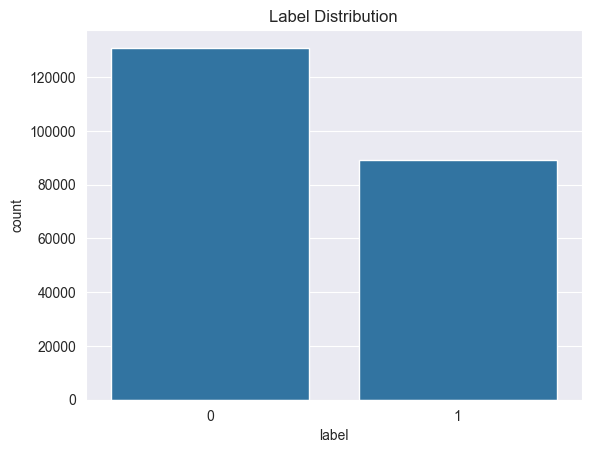

In [3]:
# Visualize class distribution
sns.countplot(data=df, x='label')
plt.title('Label Distribution')
plt.show()

In [4]:
df.duplicated().sum()

np.int64(0)

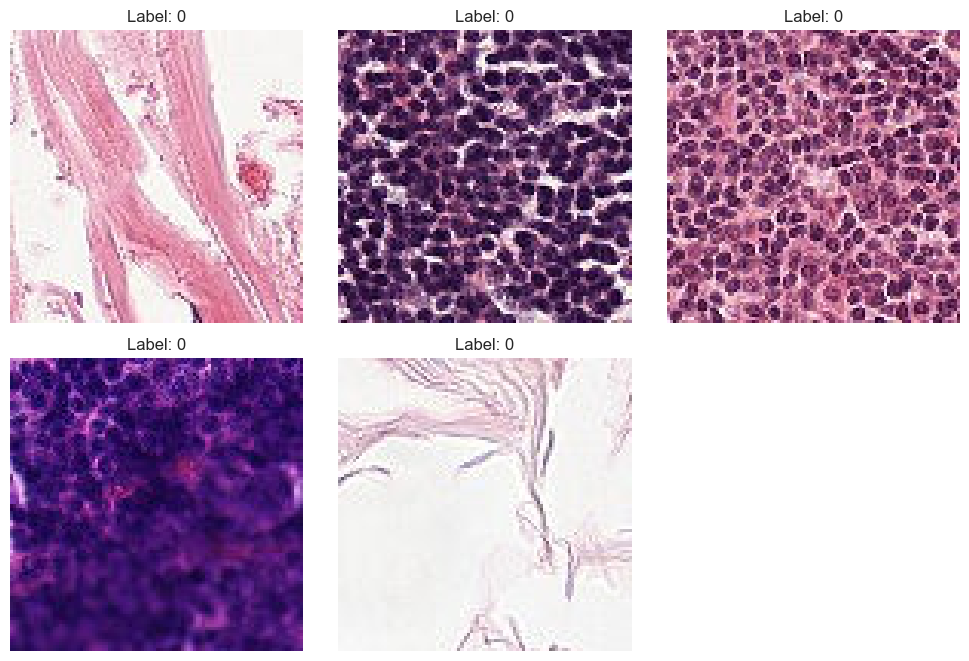

In [5]:
imgs = df[df['label'] == 0]['id'].sample(5).values
plt.figure(figsize=(10, 10))
for i, img_id in enumerate(imgs):
    img = cv2.imread(f'train/{img_id}.tif')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Label: 0')
plt.tight_layout()
plt.show()

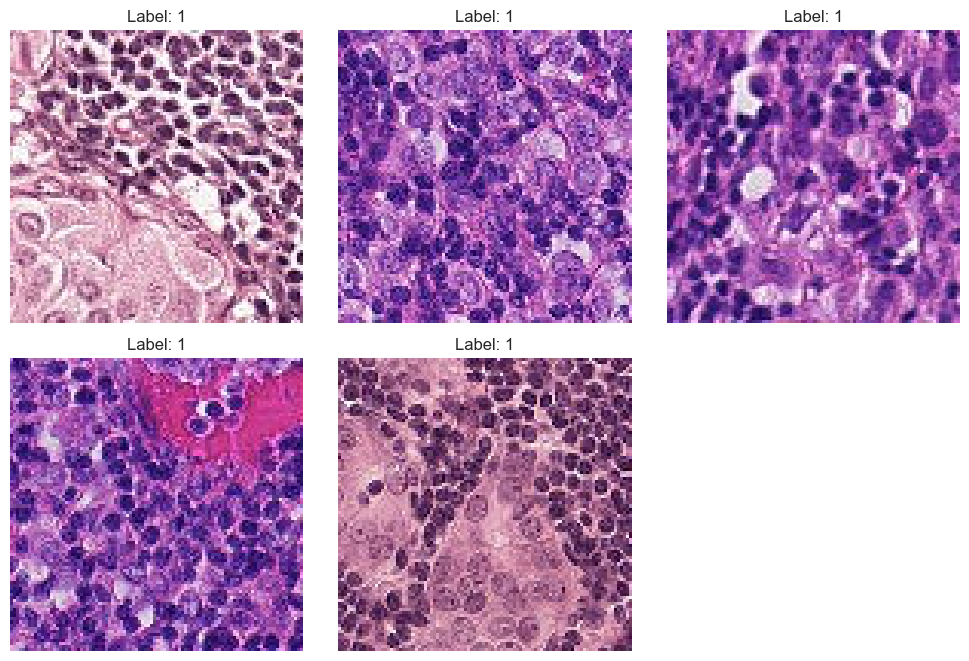

In [6]:
    imgs = df[df['label'] == 1]['id'].sample(5).values
    plt.figure(figsize=(10, 10))
    for i, img_id in enumerate(imgs):
        img = cv2.imread(f'train/{img_id}.tif')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(3, 3, i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f'Label: 1')
    plt.tight_layout()
    plt.show()

In [7]:
min_count = df.label.value_counts().min()
df_balanced = pd.concat([
    df[df.label == 0].sample(min_count, random_state=42),
    df[df.label == 1].sample(min_count, random_state=42)
])
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)
df_balanced

,id,label
0,84e2de905656d96a8f1894aa493db4dd18c67739,1
1,3e4291d96c6b4320168347bda92e7ba33b18ff91,0
2,478978eb822013bd3e58f49a75cd7b95a9a66199,0
3,8e9686c7d13147456245ffc0354f9bf739eac56d,0
4,4dbc87d82d0e7810d946fc4b20cae62d5713e5ea,1
...,...,...
178229,e60c3abcf4ffc619b9b9d4be2c17b1836caa2963,1
178230,8ac241d257da3365c1185980143d7722725dfd4e,1
178231,3a3006bc1da5eabf98bb92216d428f7ba68b119d,1
178232,ece73a6752a3f715b53a962ecce3fe1ce27a661d,1


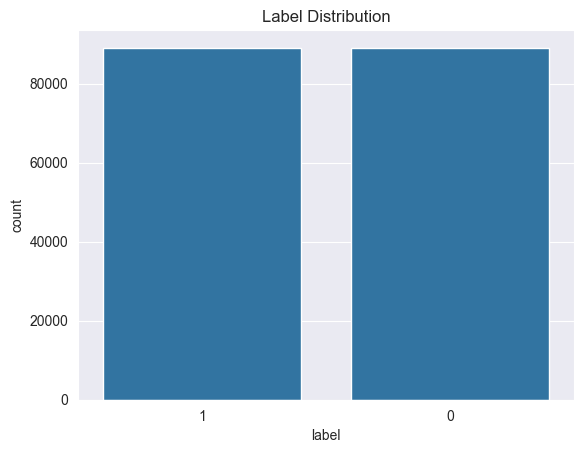

In [13]:
# Visualize balanced data distribution
sns.countplot(data=df_balanced, x='label')
plt.title('Label Distribution')
plt.show()

In [8]:
df_balanced["label"] = df_balanced["label"].apply(lambda x: str(x))
df_balanced["id"] = df_balanced["id"].apply(lambda x: x + ".tif")

In [9]:
print(tf.__version__)
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))


2.19.0
Num GPUs Available: 0


In [10]:
# Train/val split
train_df, val_df = train_test_split(df_balanced, test_size=0.2, stratify=df_balanced.label, random_state=42)


In [12]:
datagen = ImageDataGenerator(rescale=1./255)
train_gen = datagen.flow_from_dataframe(
    train_df, directory='train', x_col='id', y_col='label',
    target_size=(96, 96), class_mode='binary', batch_size=32)
val_gen = datagen.flow_from_dataframe(
    val_df, directory='train', x_col='id', y_col='label',
    target_size=(96, 96), class_mode='binary', batch_size=32)


Found 142587 validated image filenames belonging to 2 classes.
Found 35647 validated image filenames belonging to 2 classes.


In [15]:
def build_model_basic_cnn(filters, drpo):
    model = Sequential([
        Conv2D(filters, (3, 3), activation='relu', input_shape=(96, 96, 3)),
        MaxPooling2D(),
        Flatten(),
        Dense(64, activation='relu'),
        Dropout(drpo),
        Dense(1, activation='sigmoid')
    ])
    return model

cnn_models = []
for filter_cnt in {32, 64}:
    for dropout in {0, 0.25, 0.5, 0.75}:
        cnn_models.append(build_model_basic_cnn(filter_cnt, dropout))

C:\Users\Momcilo\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [17]:
def build_model_2_cnn(filters_cnt, drpo):
    model = Sequential([
        Conv2D(filters_cnt, (3, 3), activation='relu', input_shape=(96, 96, 3)),
        BatchNormalization(),
        MaxPooling2D(),
        Conv2D(filters_cnt*2, (3, 3), activation='relu'),
        MaxPooling2D(),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(drpo),
        Dense(1, activation='sigmoid')
    ])
    return model

cnn_2layer_models = []
for filter_cnt in {32, 64}:
    for dropout in {0, 0.25, 0.5, 0.75}:
        cnn_2layer_models.append(build_model_2_cnn(filter_cnt, dropout))

C:\Users\Momcilo\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
for idx, model in enumerate(cnn_models + cnn_2layer_models):
    print(f"\nTraining Model {idx + 1}...")
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    es = EarlyStopping(patience=3, restore_best_weights=True)
    history = model.fit(train_gen, validation_data=val_gen, epochs=10, callbacks=[es])
    histories.append(history)

    # Plot accuracy and loss
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Val')
    plt.title(f'Model {idx + 1} Accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Val')
    plt.title(f'Model {idx + 1} Loss')
    plt.legend()
    plt.show()


Training Model 1...


C:\Users\Momcilo\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
 883/4456 ━━━━━━━━━━━━━━━━━━━━ 4:18 72ms/step - accuracy: 0.7060 - loss: 0.9109

In [ ]:
best_model = models[-1]

# Load and predict on test data
test_df = pd.read_csv("sample_submission.csv")
test_df["id"] = test_df["id"].apply(lambda x: x + ".tif")
test_gen = datagen.flow_from_dataframe(
    test_df, directory='test', x_col='id', y_col=None,
    target_size=(IMG_SIZE, IMG_SIZE), class_mode=None, batch_size=1, shuffle=False)

preds = best_model.predict(test_gen, verbose=1)
test_df['label'] = (preds > 0.5).astype(int)

# Save submission
test_df.to_csv("submission.csv", index=False)
print("Submission file saved as submission.csv")